# Thalassemia Severity Prediction - Updated Based on Feature Engineering

## Objectives

*   Predict Thalassemia severity levels using top clinical features from feature engineering
*   Create clinically meaningful severity scoring based on hematological parameters
*   Use engineered features for better severity classification

## Key Findings from Feature Engineering (Notebook 04)

* **Top Clinical Features**: HbA2 (2.32), HbF (2.30), Hypochromia (2.21), MCV (1.77), Mentzer Index (1.62)
* **Engineered Features**: 9 new clinical indicators including Mentzer Index, microcytosis, hypochromia
* **Clinical Validation**: All major Thalassemia indicators successfully created

## Inputs

* outputs/datasets/engineered/X_train_engineered.csv
* outputs/datasets/engineered/X_test_engineered.csv  
* outputs/datasets/engineered/y_train.csv
* outputs/datasets/engineered/y_test.csv

## Outputs

* Enhanced severity scoring model
* Clinical severity classification
* Feature importance for severity prediction


---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/nour/Desktop/thalassemia_predictor_v2


# Step 1: Load Data and Focus on Top Clinical Features

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load engineered datasets
try:
    X_train = pd.read_csv("outputs/datasets/engineered/X_train_engineered.csv")
    X_test = pd.read_csv("outputs/datasets/engineered/X_test_engineered.csv")
    y_train = pd.read_csv("outputs/datasets/engineered/y_train.csv").squeeze()
    y_test = pd.read_csv("outputs/datasets/engineered/y_test.csv").squeeze()
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Available features: {X_train.columns.tolist()}")
    
    # Define severity-relevant features based on feature engineering findings
    severity_features = [
        # Top clinical features from feature engineering
        'hba2',           # Most important - β-thalassemia marker
        'hbf',            # Fetal hemoglobin - severity indicator
        'hb',             # Hemoglobin level - anemia severity
        'mcv',            # Microcytosis severity
        'mch',            # Hypochromia severity
        'rdw',            # Red cell distribution width
        # Engineered clinical indicators
        'mentzer_index',  # Diagnostic ratio
        'hypochromia',    # Clinical indicator
        'microcytosis',   # Clinical indicator
        'hba2_elevated',  # HbA2 analysis
        'rbc_hb_ratio'    # Additional ratio
    ]
    
    # Filter to available severity features
    available_severity_features = [f for f in severity_features if f in X_train.columns]
    print(f"\nSeverity-relevant features available: {len(available_severity_features)}")
    print(f"Features: {available_severity_features}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please run the feature engineering notebook first.")

Training set: (162, 20)
Test set: (41, 20)
Available features: ['sex', 'hb', 'pcv', 'rbc', 'mcv', 'mch', 'mchc', 'rdw', 'hba', 'hba2', 'hbf', 'mentzer_index', 'mentzer_thal_indicator', 'rbc_hb_ratio', 'microcytosis', 'hypochromia', 'hba2_elevated', 'hba2_normal', 'rdw_mcv_ratio', 'hba_hba2_ratio']

Severity-relevant features available: 11
Features: ['hba2', 'hbf', 'hb', 'mcv', 'mch', 'rdw', 'mentzer_index', 'hypochromia', 'microcytosis', 'hba2_elevated', 'rbc_hb_ratio']


## Enhanced Clinical Severity Scoring

Enhanced Severity Score Distribution (Training):
0     55
1     19
2     17
3     38
4     17
5      5
6      6
7      2
8      2
10     1
Name: count, dtype: int64

Enhanced Severity Category Distribution (Training):
Mild           91
Moderate       60
Severe         10
Very Severe     1
Name: count, dtype: int64


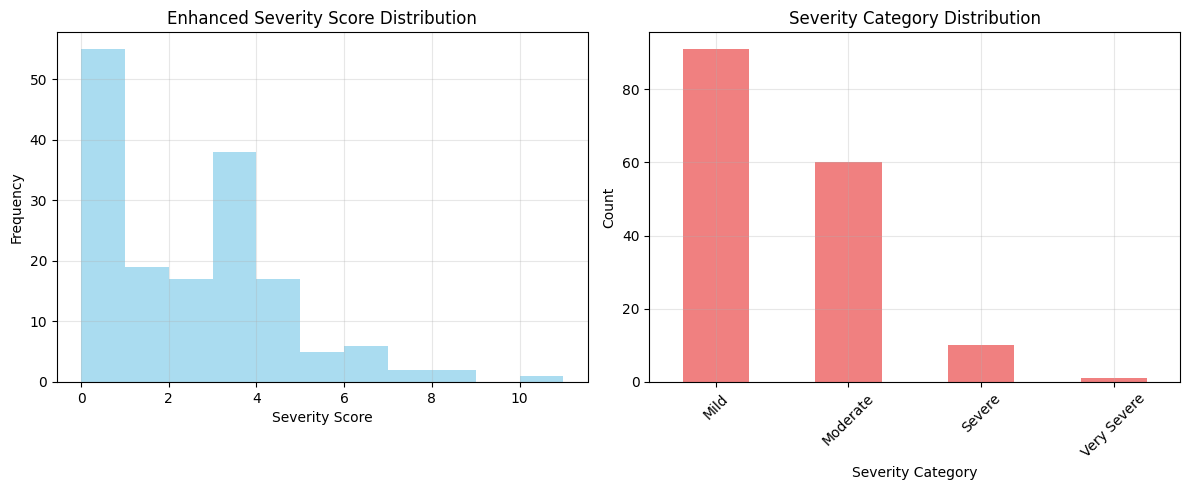

In [3]:
def create_enhanced_severity_score(df):
    """Create enhanced severity score using top clinical features"""
    severity_score = 0
    severity_components = {}
    
    # 1. Hemoglobin level (most important for clinical severity)
    if 'hb' in df.columns:
        hb_severity = np.where(df['hb'] < 6, 4,      # Severe anemia
                      np.where(df['hb'] < 8, 3,      # Moderate-severe anemia
                      np.where(df['hb'] < 10, 2,     # Moderate anemia  
                      np.where(df['hb'] < 12, 1, 0))))  # Mild anemia
        severity_score += hb_severity
        severity_components['hb_severity'] = hb_severity
    
    # 2. HbA2 levels (β-thalassemia severity marker)
    if 'hba2' in df.columns:
        hba2_severity = np.where(df['hba2'] > 7, 3,    # Very high HbA2
                        np.where(df['hba2'] > 5, 2,    # High HbA2
                        np.where(df['hba2'] > 3.5, 1, 0)))  # Mildly elevated
        severity_score += hba2_severity
        severity_components['hba2_severity'] = hba2_severity
    
    # 3. HbF levels (compensatory mechanism)
    if 'hbf' in df.columns:
        hbf_severity = np.where(df['hbf'] > 10, 2,     # Very high HbF
                       np.where(df['hbf'] > 5, 1, 0))  # Elevated HbF
        severity_score += hbf_severity
        severity_components['hbf_severity'] = hbf_severity
    
    # 4. MCV (microcytosis severity)
    if 'mcv' in df.columns:
        mcv_severity = np.where(df['mcv'] < 55, 3,     # Severe microcytosis
                       np.where(df['mcv'] < 65, 2,     # Moderate microcytosis
                       np.where(df['mcv'] < 75, 1, 0)))  # Mild microcytosis
        severity_score += mcv_severity
        severity_components['mcv_severity'] = mcv_severity
    
    # 5. MCH (hypochromia severity)
    if 'mch' in df.columns:
        mch_severity = np.where(df['mch'] < 20, 2,     # Severe hypochromia
                       np.where(df['mch'] < 25, 1, 0))  # Mild hypochromia
        severity_score += mch_severity
        severity_components['mch_severity'] = mch_severity
    
    # 6. RDW (anisocytosis)
    if 'rdw' in df.columns:
        rdw_severity = np.where(df['rdw'] > 25, 2,     # Very high RDW
                       np.where(df['rdw'] > 20, 1, 0))  # High RDW
        severity_score += rdw_severity
        severity_components['rdw_severity'] = rdw_severity
    
    # 7. Mentzer Index (if available)
    if 'mentzer_index' in df.columns:
        mentzer_severity = np.where(df['mentzer_index'] < 10, 1, 0)  # Very low Mentzer
        severity_score += mentzer_severity
        severity_components['mentzer_severity'] = mentzer_severity
    
    return severity_score, severity_components

# Create enhanced severity scores
severity_train, components_train = create_enhanced_severity_score(X_train)
severity_test, components_test = create_enhanced_severity_score(X_test)

print("Enhanced Severity Score Distribution (Training):")
print(pd.Series(severity_train).value_counts().sort_index())

# Create severity categories with better clinical thresholds
def score_to_severity_category(score):
    """Convert severity score to clinical categories"""
    if score <= 2:
        return 'Mild'
    elif score <= 5:
        return 'Moderate'
    elif score <= 8:
        return 'Severe'
    else:
        return 'Very Severe'

severity_cat_train = [score_to_severity_category(s) for s in severity_train]
severity_cat_test = [score_to_severity_category(s) for s in severity_test]

print("\nEnhanced Severity Category Distribution (Training):")
severity_dist = pd.Series(severity_cat_train).value_counts()
print(severity_dist)

# Visualize severity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
pd.Series(severity_train).hist(bins=range(int(max(severity_train))+2), alpha=0.7, color='skyblue')
plt.xlabel('Severity Score')
plt.ylabel('Frequency')
plt.title('Enhanced Severity Score Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
severity_dist.plot(kind='bar', color='lightcoral')
plt.xlabel('Severity Category')
plt.ylabel('Count')
plt.title('Severity Category Distribution')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Severity Component Analysis

Severity Component Analysis:

Mean Component Scores by Severity Category:


,hb_severity,hba2_severity,hbf_severity,mcv_severity,mch_severity,rdw_severity,mentzer_severity,total_severity
severity_category,,,,,,,,
Mild,0.13,0.0,0.01,0.18,0.26,0.00,0.00,0.58
Moderate,1.12,0.0,0.00,1.23,1.07,0.02,0.02,3.45
Severe,1.70,0.0,0.00,2.10,2.00,0.40,0.40,6.60
Very Severe,2.00,0.0,0.00,3.00,2.00,2.00,1.00,10.00


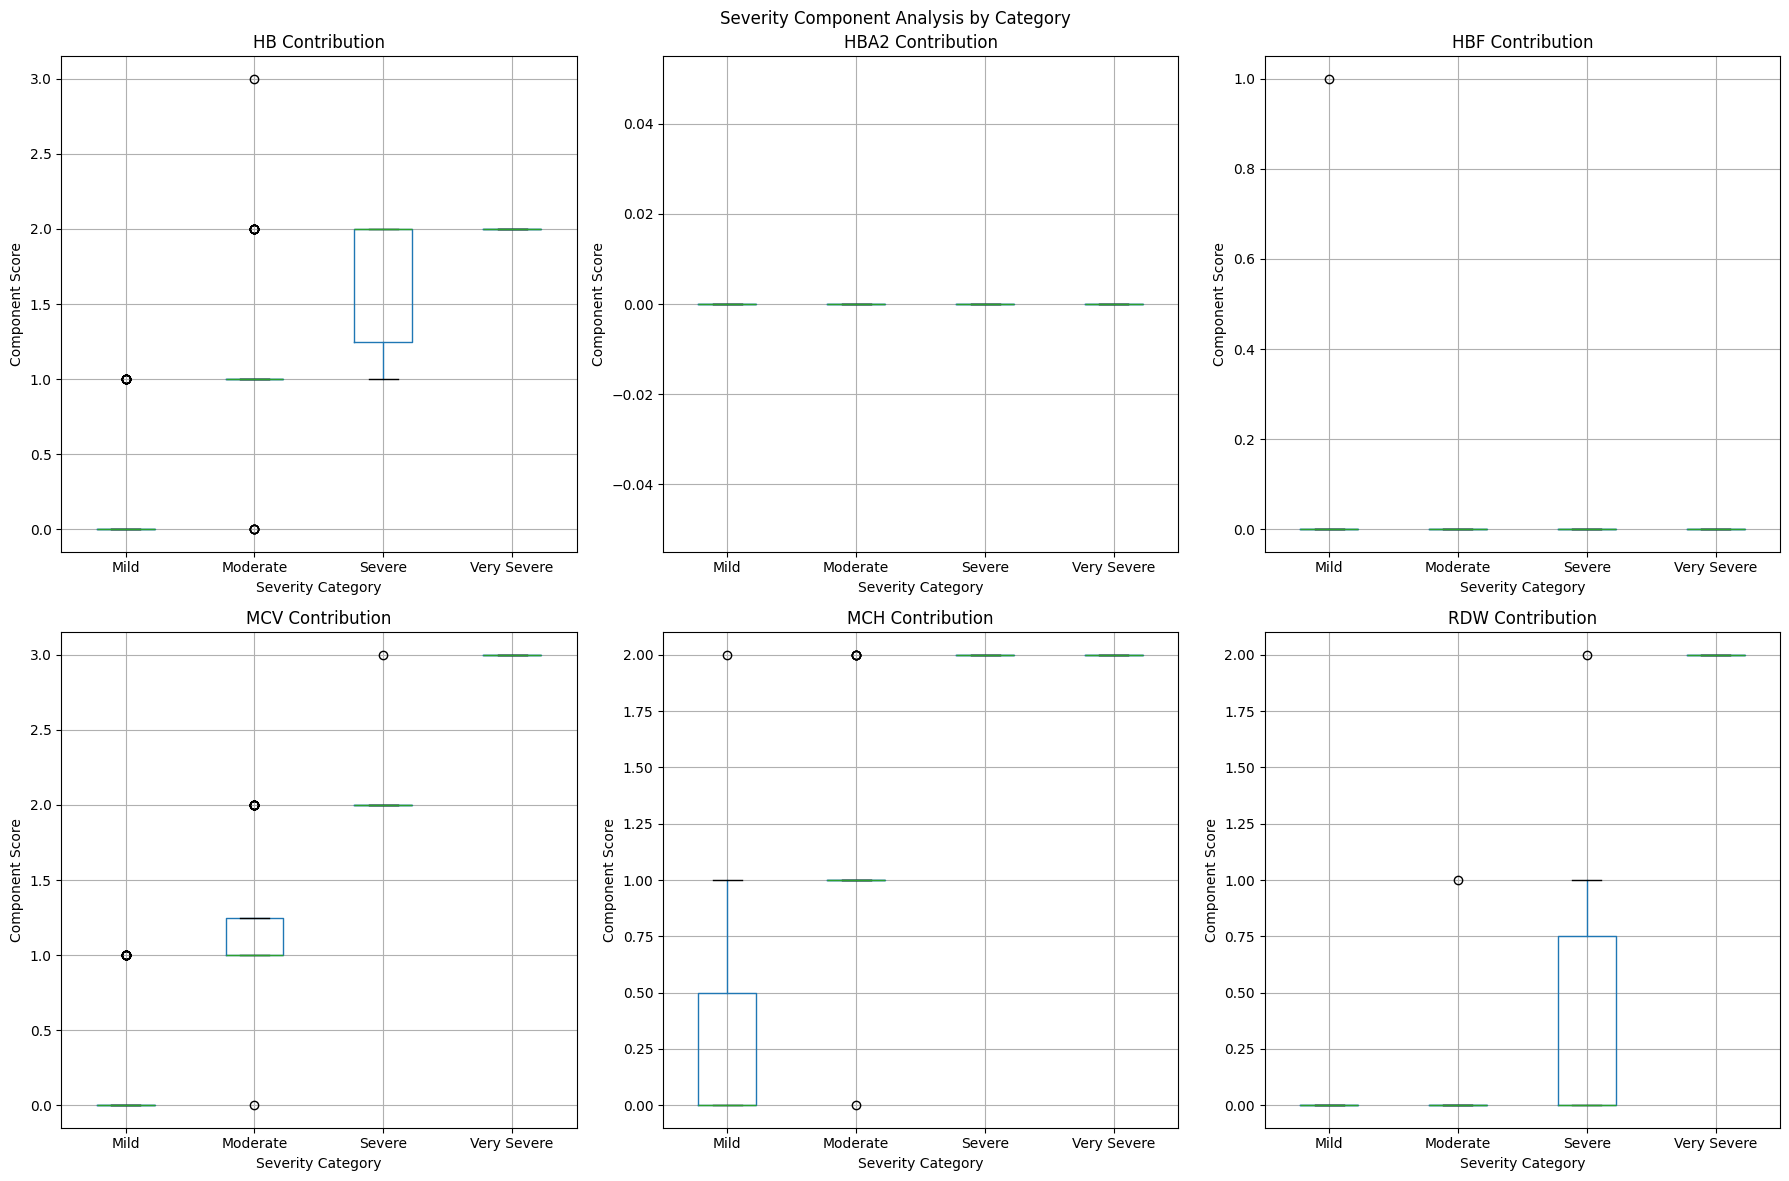


Component Correlation Matrix:


,hb_severity,hba2_severity,hbf_severity,mcv_severity,mch_severity,rdw_severity,mentzer_severity,total_severity
hb_severity,1.000,NaN,0.044,0.564,0.594,0.230,0.156,0.794
hba2_severity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hbf_severity,0.044,NaN,1.000,-0.073,-0.082,-0.013,-0.015,-0.003
mcv_severity,0.564,NaN,-0.073,1.000,0.801,0.350,0.377,0.903
mch_severity,0.594,NaN,-0.082,0.801,1.000,0.303,0.346,0.894
rdw_severity,0.230,NaN,-0.013,0.350,0.303,1.000,0.349,0.466
mentzer_severity,0.156,NaN,-0.015,0.377,0.346,0.349,1.000,0.443
total_severity,0.794,NaN,-0.003,0.903,0.894,0.466,0.443,1.000


In [4]:
# Analyze contribution of each component to severity
component_df = pd.DataFrame(components_train)
component_df['total_severity'] = severity_train
component_df['severity_category'] = severity_cat_train

print("Severity Component Analysis:")
print("=" * 50)

# Calculate mean contribution of each component
component_means = component_df.groupby('severity_category').mean()
print("\nMean Component Scores by Severity Category:")
display(component_means.round(2))

# Visualize component contributions
if len(component_df.columns) > 2:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    component_cols = [col for col in component_df.columns if col.endswith('_severity')]
    
    for i, component in enumerate(component_cols[:6]):
        if i < len(axes):
            component_df.boxplot(column=component, by='severity_category', ax=axes[i])
            axes[i].set_title(f'{component.replace("_severity", "").upper()} Contribution')
            axes[i].set_xlabel('Severity Category')
            axes[i].set_ylabel('Component Score')
    
    # Hide unused subplots
    for i in range(len(component_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Severity Component Analysis by Category')
    plt.tight_layout()
    plt.show()

# Correlation analysis between components
print("\nComponent Correlation Matrix:")
component_corr = component_df[[col for col in component_df.columns if col.endswith('_severity')]].corr()
display(component_corr.round(3))

# Step 2: Severity Prediction Modeling

In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier

# Prepare data for modeling
X_severity_train = X_train[available_severity_features].copy()
X_severity_test = X_test[available_severity_features].copy()

# Encode severity categories
severity_encoder = LabelEncoder()
y_severity_train = severity_encoder.fit_transform(severity_cat_train)
y_severity_test = severity_encoder.transform(severity_cat_test)

print(f"Severity modeling dataset:")
print(f"Training: {X_severity_train.shape}")
print(f"Test: {X_severity_test.shape}")
print(f"Severity classes: {severity_encoder.classes_}")
print(f"Class distribution: {pd.Series(y_severity_train).value_counts().sort_index()}")

# Check if we have enough samples for each class
class_counts = pd.Series(y_severity_train).value_counts()
min_class_size = class_counts.min()
print(f"\nMinimum class size: {min_class_size}")

if min_class_size < 5:
    print("⚠️  Warning: Some severity classes have very few samples. Consider:")
    print("   - Combining similar severity levels")
    print("   - Using regression instead of classification")
    print("   - Collecting more data")

Severity modeling dataset:
Training: (162, 11)
Test: (41, 11)
Severity classes: ['Mild' 'Moderate' 'Severe' 'Very Severe']
Class distribution: 0    91
1    60
2    10
3     1
Name: count, dtype: int64

Minimum class size: 1
⚠️  Warning: Some severity classes have very few samples. Consider:
   - Combining similar severity levels
   - Using regression instead of classification
   - Collecting more data


## Model Training and Evaluation

In [6]:
# Define models suitable for severity prediction
severity_models = {
    'RandomForest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=5,
        min_samples_split=5,
        class_weight='balanced'
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1
    ),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        eval_metric='mlogloss'
    )
}

# Cross-validation evaluation
cv_results = {}
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Severity Prediction Model Evaluation:")
print("=" * 60)
print(f"{'Model':<20} {'F1-Weighted':<12} {'F1-Macro':<12} {'Accuracy':<10}")
print("-" * 60)

for name, model in severity_models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    try:
        # Cross-validation scores
        f1_weighted_scores = cross_val_score(
            pipeline, X_severity_train, y_severity_train,
            cv=cv_strategy, scoring='f1_weighted', n_jobs=-1
        )
        f1_macro_scores = cross_val_score(
            pipeline, X_severity_train, y_severity_train,
            cv=cv_strategy, scoring='f1_macro', n_jobs=-1
        )
        accuracy_scores = cross_val_score(
            pipeline, X_severity_train, y_severity_train,
            cv=cv_strategy, scoring='accuracy', n_jobs=-1
        )
        
        cv_results[name] = {
            'f1_weighted': f1_weighted_scores.mean(),
            'f1_macro': f1_macro_scores.mean(),
            'accuracy': accuracy_scores.mean()
        }
        
        print(f"{name:<20} {f1_weighted_scores.mean():<12.3f} "
              f"{f1_macro_scores.mean():<12.3f} {accuracy_scores.mean():<10.3f}")
        
    except Exception as e:
        print(f"{name:<20} Error: {str(e)[:40]}...")
        cv_results[name] = {'f1_weighted': 0, 'f1_macro': 0, 'accuracy': 0}

# Select best model
if cv_results:
    best_severity_model = max(cv_results.keys(), key=lambda k: cv_results[k]['f1_weighted'])
    print(f"\nBest Model: {best_severity_model}")
    print(f"F1-Weighted Score: {cv_results[best_severity_model]['f1_weighted']:.3f}")
else:
    print("\nNo models could be evaluated successfully.")
    best_severity_model = 'RandomForest'

Severity Prediction Model Evaluation:
Model                F1-Weighted  F1-Macro     Accuracy  
------------------------------------------------------------
RandomForest         0.912        0.825        0.914     
GradientBoosting     0.936        0.723        0.938     
XGBoost              0.930        0.853        0.932     

Best Model: GradientBoosting
F1-Weighted Score: 0.936
